In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

train_X.shape: (2, 211), train_Y.shape: (1, 211), test_X.shape: (2, 200), test_Y.shape: (1, 200)


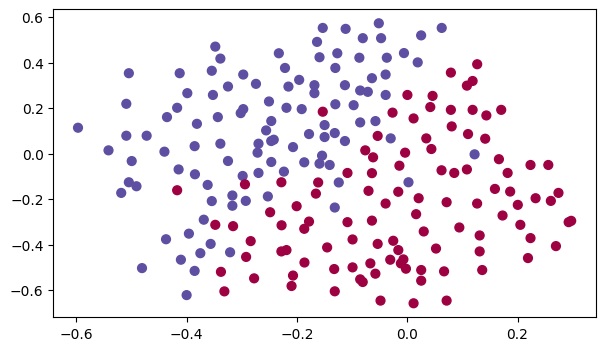

In [2]:
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    # Plot training data
    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);

    return train_X, train_Y, test_X, test_Y
train_X, train_Y, test_X, test_Y = load_2D_dataset()
print(f'train_X.shape: {train_X.shape}, train_Y.shape: {train_Y.shape}, test_X.shape: {test_X.shape}, test_Y.shape: {test_Y.shape}')

In [3]:
def initialize_parameters(layers_dims):
    # In accordance with lab so as to verify results
    np.random.seed(3)

    L = len(layers_dims)    
    parameters = {}
    for l in range(1, L):
        parameters[f'W{l}'] = np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1])
        parameters[f'b{l}'] = np.zeros((layers_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layers_dims[l], 1))
    
    '''print(f'Initialized parameters:')
    for key in parameters:
        print(f'{key} shape: {parameters[key].shape}')'''
        
    return parameters

In [4]:
def forward_linear(A_prev, W, b):
    Z = np.dot(W, A_prev) + b

    #print(f'Calculated Z, shape: {Z.shape}')
    
    return Z

In [5]:
def forward_activation(Z, activation):
    if activation=='relu':
        A = relu(Z)
        #print(f'Calculated A=relu(Z), shape: {A.shape}')
        return A
    elif activation=='sigmoid':
        A = sigmoid(Z)
        #print(f'Calculated A = sigmoid(Z): {A.shape}')
        return A
    else:
        return Z

In [6]:
def cost(AL, Y, epsilon=1e-8):
    J = - np.sum((Y * np.log(AL+ epsilon)) + (1 - Y) * np.log(1-AL + epsilon)) / Y.shape[1]
   # print(f'Calculated J = {J}, J type: {type(J)}')
    return np.squeeze(J)

In [7]:
def cost_grad(AL, Y, epsilon=1e-8):
    dAL = -(np.divide(Y, AL+epsilon) - np.divide(1 - Y, 1 - AL + epsilon))
   # print(f'Calculated dAL, shape: {dAL.shape}')
    return dAL

In [8]:
def d_Z(dA, Z, activation):
    if activation == 'relu':
        dZ = dA * relu_prime(Z)
        #print(f'Calculated dZ, relu layer, shape:{dZ.shape}')
        return dZ
    elif activation == 'sigmoid':
        dZ = dA * sigmoid_prime(Z)
       # print(f'Calculated dZ, sigmoid layer, shape:{dZ.shape}')
        return dZ

In [9]:
def relu_prime(Z):
    g_prime = np.where(Z >= 0, 1, 0)
    #print(f'Calculated relu prime, shape: {g_prime.shape}')
    return g_prime

def relu(Z):
    A = np.maximum(0, Z)
    return A

In [10]:
def sigmoid_prime(Z):
    a = sigmoid(Z)
    g_prime = a * (1 - a)
   # print(f'Calculated sigmoid prime, shape: {g_prime.shape}')    
    return g_prime

def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    return A

In [11]:
def backprop_layer(dA, cache, activation):
    m = dA.shape[1]
    A_prev, Z, W, b = cache
    
    dZ = d_Z(dA, Z, activation)
    dA_prev =  np.dot(W.T, dZ) 
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ,axis=1, keepdims=True) / m
    
    return dA_prev, dW, db

In [12]:
def backward_propagation(AL, Y, caches):
    #print('backprop started...')
    
    m = Y.shape[1]
    grads = {}
    L = len(caches)
    
    #print(f'm={m}, L={L}')
    
    # Sigmoid layer L
    current_cache = caches[f'layer{L}']
    A_prev, Z, W, b = current_cache
    dAL = cost_grad(AL, Y)
    grads[f'dA{L}'] = dAL
    #print(f"grads[f'dA{L}'] done with dA{L} shape: {grads[f'dA{L}'].shape}")
    
    dA_prev, dW, db = backprop_layer(dAL, current_cache, activation='sigmoid')
    grads[f'dA{L-1}'] = dA_prev
    grads[f'dW{L}'] = dW
    grads[f'db{L}'] = db
    
    for l in range(L-1, 0, -1):
              
        current_cache = caches[f'layer{l}']
        A_prev, Z, W, b = current_cache 
        dA_prev, dW, db = backprop_layer(grads[f'dA{l}'], current_cache, activation='relu')
        grads[f'dA{l-1}'] = dA_prev
        grads[f'dW{l}'] = dW
        grads[f'db{l}'] = db
    
    return grads

In [13]:
train_Y.shape

(1, 211)

In [14]:
def forward_propagation(X, parameters): 
    caches= {}
    A_prev = X
    L = len(parameters)//2
    
    # relu params W1 to WL-1 second last layer
    for l in range(1, L):
        W = parameters[f'W{l}']
        b = parameters[f'b{l}']
        Z = forward_linear(A_prev, W, b)
        A = forward_activation(Z, activation='relu')
        caches[f'layer{l}'] = (A_prev, Z, W, b)
        A_prev = A
    
    # for params WL-1 last layer
    WL = parameters[f'W{L}']
    bL = parameters[f'b{L}']
    ZL = forward_linear(A_prev, WL, bL)
    AL = forward_activation(ZL, activation='sigmoid')
    caches[f'layer{L}'] = (A_prev, ZL, WL, bL) 
    
    return AL, caches

In [15]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters)//2

    for l in range(1, L + 1):
        parameters[f'W{l}'] -= learning_rate * grads[f'dW{l}']
        parameters[f'b{l}'] -= learning_rate * grads[f'db{l}']
    return parameters

In [16]:
# fffffff
def flatten_parameters(parameters):
    """
    Flatten parameters dictionary into a single vector.

    """
    theta = np.array([]).reshape(-1,1)

    for key in parameters.keys():
        new_vector = parameters[key].reshape((-1, 1))
        theta = np.concatenate((theta, new_vector), axis=0)

    return theta
    
def unflatten_parameters(theta, parameter_shapes, prefix=''):
    """
    Unflatten vector back into the parameters dictionary.
    Args:
    theta (ndarray)(1,): flattened parameters
    parameter_shapes (dict): Shapes of parameters, {W1 : W1.shape, ...} for all parameters
    prefix (string): Prefix to apply to keys when unrolled
    
    Returns:
    parameters (dict): Unflattened dictionary {dW1, db1,...}
    """
    parameters = {}
    start = 0

    for key in parameter_shapes.keys():
        shape = parameter_shapes[key]
        size = np.prod(shape)
        parameters[f'{prefix}{key}'] = theta[start:start + size].reshape(shape)
        start += size

    return parameters

def order_parameters(parameters):
    '''
    Orders parameters in ascending order as  dW1, db1, dW2, db2, ...
    '''
    tmp = {}
    for i in range(1, (len(parameters)//2) + 1):
        tmp[f'dW{i}'] = parameters[f'dW{i}']
        tmp[f'db{i}'] = parameters[f'db{i}']
    return tmp    
    
def compute_numerical_gradient(X, Y, 
                               parameters, 
                               forward_propagation, 
                               forwardprop_args,
                               cost_function, 
                               cost_args, 
                               epsilon=1e-7):
    """
    Compute the numerical gradient for gradient checking.
    parameters (dict): Contains Ws and bs
    """
    theta = flatten_parameters(parameters)
    #print('theta shape: ', theta.shape)
    
    parameter_shapes = {key: parameters[key].shape for key in parameters.keys()}
    print(parameter_shapes)
    
    # # parameters including those in Ws and bs
    num_total_parameters = theta.shape[0]
    #print('total params: ', num_total_parameters)
   
    # array of numerical gradient of each parameter
    numerical_gradients = np.zeros((num_total_parameters, 1))
    #print('num_grad shape: ', numerical_gradients.shape)
    
    J_plus = np.zeros((num_total_parameters, 1))
    J_minus = np.zeros((num_total_parameters, 1))

    for i in range(num_total_parameters):
        theta_plus = np.copy(theta)
        theta_minus = np.copy(theta)

        theta_plus[i] += epsilon
        theta_minus[i] -= epsilon
        
        params_plus = unflatten_parameters(theta_plus, parameter_shapes)
        params_minus = unflatten_parameters(theta_minus, parameter_shapes)

        AL_plus, _ = forward_propagation(X, params_plus, **forwardprop_args)
        AL_minus, _ = forward_propagation(X, params_minus, **forwardprop_args)


        if cost_function=='l2_cost':
            J_plus[i] = L2_cost(AL_plus, Y, params_plus, **cost_args)
            J_minus[i] = L2_cost(AL_minus, Y, params_minus, **cost_args)
        elif cost_function=='standard':
            J_plus[i] = cost(AL_plus, Y, **cost_args)
            J_minus[i] = cost(AL_minus, Y, **cost_args)
        
        numerical_gradients[i] = (J_plus[i] - J_minus[i]) / (2*epsilon)

    #print('final num_grads shape: ', numerical_gradients.shape)
    return unflatten_parameters(numerical_gradients, parameter_shapes, prefix='d')


def gradient_checking(X, Y, 
                      parameters, 
                      forward_propagation,
                      backward_propagation, 
                      forwardprop_args={},
                      backprop_args = {},
                      cost_function='standard', 
                      cost_args={}):

    gradapprox = compute_numerical_gradient(X, Y, 
                                            parameters, 
                                            forward_propagation, 
                                            forwardprop_args,
                                            cost_function, 
                                            cost_args)
    
    print(f'gradaaprox keys: {gradapprox.keys()}')
    
    AL, caches = forward_propagation(X, parameters, **forwardprop_args)
    grads = backward_propagation(AL, Y, caches, **backprop_args)

    # Filter out non-parameter gradients dA
    keys_to_remove = [key for key in grads if key.startswith("dA")]
    for key in keys_to_remove:
        del grads[key]
        

    # order of keys are different in grads and gradapprox. imrove this later.
    # grads store derivatives in reverse order due to backprop db3, dW3, ...
    # Order keys of grads before flattening it
    grads = order_parameters(grads)
    print(f'grads keys: {grads.keys()}')
  
    gradapprox = flatten_parameters(gradapprox)
    grads = flatten_parameters(grads)
    print('flattened grads shape: ', grads.shape)
    print('flattened gradapprox shape: ', gradapprox.shape)


    # Difference
    numerator = np.linalg.norm(grads - gradapprox)
    denominator = np.linalg.norm(grads) + np.linalg.norm(gradapprox)
    difference = numerator / denominator

    if True:
        
        if difference > 2e-7:
            print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
        else:
            print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")

    return difference
    

In [17]:
def model(X, Y, layers_dims, num_iters=30000, epsilon=1e-8, learning_rate=0.3, lambd=0.0, keep_prob=1):
    costs = []
    L = len(layers_dims)
    L = L - 1 # remove X which isn't layer
    m = X.shape[1]
    
    parameters = initialize_parameters(layers_dims)
    
    for i in range(num_iters):

        if keep_prob == 1:
            AL, caches = forward_propagation(X, parameters)
        elif keep_prob < 1:
            AL, caches = forward_propagation_with_dropout(X, parameters, keep_prob)

       # AL = np.clip(AL, epsilon, 1 - epsilon)
        
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(AL, Y, caches)
        elif lambd != 0:
            grads = L2_backpropagation(AL, Y, caches, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(AL, Y, caches, keep_prob)

            
        parameters = update_parameters(parameters, grads, learning_rate)

         # Print the loss every 10000 iterations
        if lambd:
            J = L2_cost(AL, Y, parameters, lambd)
        else:
            J = cost(AL, Y)
            
        if i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, J))
        if i % 1000 == 0:
            costs.append(J)

    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    

    return parameters, grads


In [18]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    Args:
    X (ndarray): data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    L = len(parameters)//2
    AL, caches = forward_propagation(X, parameters)
    p = np.int64(AL > 0.5)
    print(f'Accuracy: {np.mean(p == y)}')
    
    return p

Cost after iteration 0: 0.6557412330331666
Cost after iteration 10000: 0.16485527326915653
Cost after iteration 20000: 0.1396262576285026


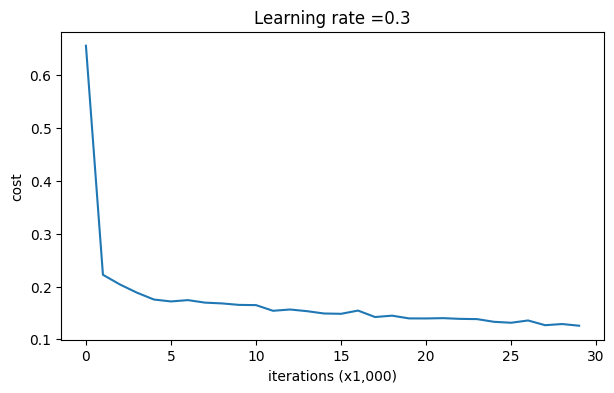

In [19]:
layers_dims = [train_X.shape[0], 20, 3, 1]
parameters, grads = model(train_X, train_Y, layers_dims, learning_rate = 0.3)

In [20]:
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [21]:
difference = gradient_checking(train_X, train_Y, parameters, forward_propagation, backward_propagation)

{'W1': (20, 2), 'b1': (20, 1), 'W2': (3, 20), 'b2': (3, 1), 'W3': (1, 3), 'b3': (1, 1)}
gradaaprox keys: dict_keys(['dW1', 'db1', 'dW2', 'db2', 'dW3', 'db3'])
grads keys: dict_keys(['dW1', 'db1', 'dW2', 'db2', 'dW3', 'db3'])
flattened grads shape:  (127, 1)
flattened gradapprox shape:  (127, 1)
Your backward propagation works perfectly fine! difference = 1.1228779851018906e-09


In [22]:
def L2_backpropagation(AL, Y, caches, lambd):
    L = len(caches)
    m = Y.shape[1]
    grads = backward_propagation(AL, Y, caches)
    
    for l in range(1, L+1):
        (A_prev, Z, W, b) = caches[f'layer{l}']
        grads[f'dW{l}'] += (lambd/m) * W
    return grads
# All tests passed.

def L2_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters)//2
    cross_entropy_cost = cost(AL, Y)

    L2_regularization_cost = 0
    for l in range(1, L+1):
        L2_regularization_cost += np.sum(np.square(parameters[f'W{l}']))
    
    L2_regularization_cost = L2_regularization_cost * (lambd/(2*m))
    
    total_cost = cross_entropy_cost + L2_regularization_cost

    return total_cost
# All tests passed


Cost after iteration 0: 0.6587271965523959
Cost after iteration 10000: 0.18355446195432684
Cost after iteration 20000: 0.17964448476572856


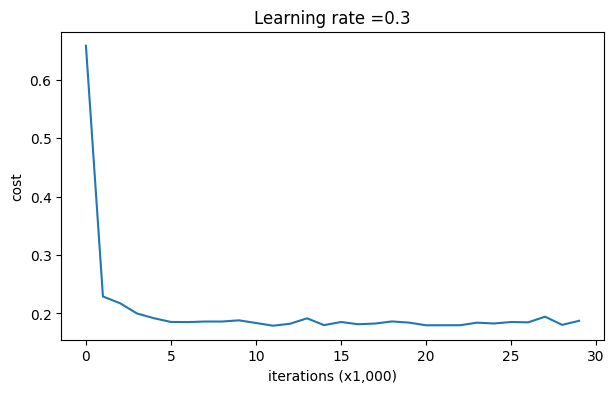

In [23]:
l2_parameters, l2_grads = model(train_X, train_Y, layers_dims, lambd=0.05)    

In [24]:
print ("On the training set:")
predictions_train = predict(train_X, train_Y, l2_parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, l2_parameters)

On the training set:
Accuracy: 0.943127962085308
On the test set:
Accuracy: 0.94


#### gradient checking for L2 regularization

In [25]:
from functools import partial

In [26]:
difference = gradient_checking(train_X, train_Y, 
                               l2_parameters, 
                               forward_propagation, 
                               partial(L2_backpropagation, lambd=0.05),
                               backprop_args={'lambd': 0.05},
                               cost_function= 'l2_cost',
                               cost_args = {'lambd': 0.05}
                            )

{'W1': (20, 2), 'b1': (20, 1), 'W2': (3, 20), 'b2': (3, 1), 'W3': (1, 3), 'b3': (1, 1)}
gradaaprox keys: dict_keys(['dW1', 'db1', 'dW2', 'db2', 'dW3', 'db3'])
grads keys: dict_keys(['dW1', 'db1', 'dW2', 'db2', 'dW3', 'db3'])
flattened grads shape:  (127, 1)
flattened gradapprox shape:  (127, 1)
Your backward propagation works perfectly fine! difference = 2.537390876701461e-09


### Dropout

Implement the forward propagation with dropout. Add dropout to the middle hidden layers. **We will not apply dropout to the input layer or output layer.**

In [27]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    np.random.seed(1)

    caches= {}
    A_prev = X
    L = len(parameters)//2  
    
    # relu params W1 to WL-1 second last layer
    for l in range(1, L):
        W = parameters[f'W{l}']
        b = parameters[f'b{l}']
        Z = forward_linear(A_prev, W, b)
        A = forward_activation(Z, activation='relu')

        # Dropout
        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype('int')
        A = A * D
        A /= keep_prob

        # Store caches
        caches[f'layer{l}'] = (A_prev, Z, W, b, D)
        A_prev = A
    
    # for params WL-1 last layer No Dropout
    WL = parameters[f'W{L}']
    bL = parameters[f'b{L}']
    ZL = forward_linear(A_prev, WL, bL)
    AL = forward_activation(ZL, activation='sigmoid')
    caches[f'layer{L}'] = (A_prev, ZL, WL, bL) 
    
    return AL, caches
# All tests passed

Implement the backward propagation with dropout. Add dropout to the middle hidden layers, using the masks $D$ stored in the cache.

In [28]:
def backward_propagation_with_dropout(AL, Y, caches, keep_prob):    
    m = Y.shape[1]
    grads = {}
    L = len(caches)
        
    # Sigmoid layer L
    current_cache = caches[f'layer{L}']
    A_prev, Z, W, b  = current_cache
    dAL = cost_grad(AL, Y)
    grads[f'dA{L}'] = dAL
    
    dA_prev, dW, db = backprop_layer(dAL, current_cache, activation='sigmoid')
    #print(f'dA{L-1}')
    grads[f'dA{L-1}'] = dA_prev
    grads[f'dW{L}'] = dW
    grads[f'db{L}'] = db

    _, _, _, _, D = caches[f'layer{L-1}'] 
    grads[f'dA{L-1}'] *= (D / keep_prob) 
    #print(f'dA{L-1}*D{L-1}')


    for l in reversed(range(1, L)):
        #print(f'layer{l}:')
        A_prev, Z, W, b, D = caches[f'layer{l}']
        current_cache = (A_prev, Z, W, b)  # expected in backprop_layer()
        dA_prev, dW, db = backprop_layer(grads[f'dA{l}'], current_cache, activation='relu')
       
        grads[f'dA{l-1}'] = dA_prev
        #print(f'dA{l-1}')
        grads[f'dW{l}'] = dW
        grads[f'db{l}'] = db

        if l > 1:
            _, _, _, _, D = caches[f'layer{l-1}'] 
            grads[f'dA{l-1}'] *= (D / keep_prob) 
            #print(f'dA{l-1}*D{l-1}')


        '''# Dropout steps
        print(f'dA{l}*D{l}')
        grads[f'dA{l}'] *= (D / keep_prob)'''


    return grads
# All tests passed

Cost after iteration 0: 0.6543912212036612
Cost after iteration 10000: 0.061049372236261355
Cost after iteration 20000: 0.06054599418236274


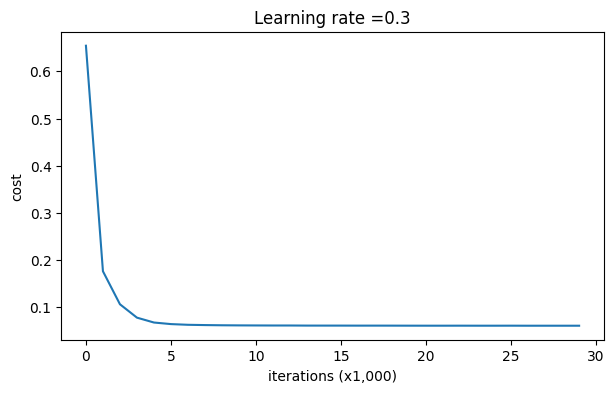

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


In [29]:
parameters, grads = model(train_X, train_Y, layers_dims, keep_prob=0.86, learning_rate = 0.3)    

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

### Gradient check for Dropout


In [33]:
gradient_checking(train_X, train_Y, 
                      parameters, 
                      forward_propagation_with_dropout,
                      backward_propagation_with_dropout, 
                      forwardprop_args={'keep_prob': 1.0},
                      backprop_args = {'keep_prob': 1.0},
                      )

{'W1': (20, 2), 'b1': (20, 1), 'W2': (3, 20), 'b2': (3, 1), 'W3': (1, 3), 'b3': (1, 1)}
gradaaprox keys: dict_keys(['dW1', 'db1', 'dW2', 'db2', 'dW3', 'db3'])
grads keys: dict_keys(['dW1', 'db1', 'dW2', 'db2', 'dW3', 'db3'])
flattened grads shape:  (127, 1)
flattened gradapprox shape:  (127, 1)
There is a mistake in the backward propagation! difference = 0.0009529495578159756


0.0009529495578159756

ChatGPT : 
Gradient Checking

### Dropout Effect on Gradient Checking:

- When dropout is enabled (keep_prob < 1), the stochastic dropout masks introduce non-smooth, discrete behavior in the network.
- This leads to inconsistencies between the forward propagation used for numerical gradient approximation and that in backpropagation.
- Disable dropout (set keep_prob = 1) during gradient checking to ensure a smooth, deterministic function.

### Acceptable Numerical Differences:

- Even with dropout disabled, the finite difference method introduces small numerical errors due to floating point precision.
- A relative difference on the order of ~0.001 (e.g., 0.00095) is typically acceptable.
- The threshold of 2e-7 is overly strict; relaxing the threshold (e.g., to ~1e-3) is advisable when assessing backpropagation correctness.

### Optimization Algos

### Batch GD : GD wrt all m examples

In [28]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    L = len(parameters) // 2

    for i in range(1, L+1):
        parameters[f'W{i}'] -= learning_rate * grads[f'dW{i}']
        parameters[f'b{i}'] -= learning_rate * grads[f'db{i}']
    
    return parameters

# All tests passed

### Mini batch GD

There are two steps:
- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches.
- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full `mini_batch_size`.

Note that the last mini-batch might end up smaller than `mini_batch_size=64`. Let $\lfloor s \rfloor$ represents $s$ rounded down to the nearest integer (this is `math.floor(s)` in Python). If the total number of examples is not a multiple of `mini_batch_size=64` then there will be $\left\lfloor \frac{m}{mini\_batch\_size}\right\rfloor$ mini-batches with a full 64 examples, and the number of examples in the final mini-batch will be $\left(m-mini_\_batch_\_size \times \left\lfloor \frac{m}{mini\_batch\_size}\right\rfloor\right)$. 

**Hint:**

$$mini\_batch\_X = shuffled\_X[:, i : j]$$ 

Think of a way in which you can use the for loop variable `k` help you increment `i` and `j` in multiples of mini_batch_size.

In [29]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
        """
        Creates a list of random minibatches from (X, Y)
        
        Arguments:
        X -- input data, of shape (input size, number of examples)
        Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
        mini_batch_size -- size of the mini-batches, integer
        
        Returns:
        mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
        """
        np.random.seed(seed)  # Grading purspose
        
        m = X.shape[1]
        mini_batches = []
    
        # Shuffle
        indices = list(np.random.permutation(m))
        X = X[:, indices]
        Y = Y[:, indices].reshape((1,m))
    
        inc = mini_batch_size
    
        # Partition
        num_complete_mini_batches = math.floor(m/inc)
    
        for k in range(num_complete_mini_batches):
            mini_batch_X = X[:, k * inc : (k + 1) * inc]
            mini_batch_Y = Y[:, k * inc : (k + 1) * inc]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
    
        # end case where last batch has < mini_batch_size examples
        mini_batch_X = X[:, num_complete_mini_batches * mini_batch_size : m]
        mini_batch_Y = Y[:, num_complete_mini_batches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
        return mini_batches
    
    # All tests passed    

<font color='blue'>
    
**What you should remember**:
- Shuffling and Partitioning are the two steps required to build mini-batches
- Powers of two are often chosen to be the mini-batch size, e.g., 16, 32, 64, 128.
    

### Momentum

In [30]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """

    L = len(parameters) // 2
    v = {}

    for l in range(1, L+1):
        v[f'dW{l}'] = np.zeros(parameters[f'W{l}'].shape)
        v[f'db{l}'] = np.zeros(parameters[f'b{l}'].shape)
    
    return v

# All tests passed

<a name='ex-4'></a>   
### Exercise 4 - update_parameters_with_momentum

Now, implement the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  Note that the iterator `l` starts at 1 in the `for` loop as the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript).

In [31]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """
    L = len(parameters) // 2

    for l in range(1, L+1):
        v[f'dW{l}'] = beta * v[f'dW{l}'] + (1 - beta) * grads[f'dW{l}']
        v[f'db{l}'] = beta * v[f'db{l}'] + (1 - beta) * grads[f'db{l}']

        
        parameters[f'W{l}'] -= learning_rate * v[f'dW{l}']
        parameters[f'b{l}'] -= learning_rate * v[f'db{l}']

    return parameters, v

# All tests passed

**Note that**:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update, because it takes the past gradients into account more. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might require trying several values to see what works best in terms of reducing the value of the cost function $J$. 

<font color='blue'>
    
**What you should remember**:
- Momentum takes past gradients into account to smooth out the steps of gradient descent. It can be applied with batch gradient descent, mini-batch gradient descent or stochastic gradient descent.
- You have to tune a momentum hyperparameter $\beta$ and a learning rate $\alpha$.

### Adam

<a name='5'></a>   
## 5 - Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 
# $$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, all parameters are stored in the `parameters` dictionary  

<a name='ex-5'></a>   
##### 5 initialize_adam

Initialize the Adam variables $v, s$ which keep track of the past information.

**Instruction**: The variables $v, s$ are python dictionaries that need to be initialized with arrays of zeros. Their keys are the same as for `grads`, that is:
for $l = 1, ..., L$:
```python
v["dW" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l)])
v["db" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l)])
s["dW" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l)])
s["db" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l)])

```

In [32]:
def initialize_adam(parameters):
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient. Initialized with zeros.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient. Initialized with zeros.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    L = len(parameters) // 2
    v = {}
    s = {}

    for l in range(1, L+1):
        v['dW' + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        v['db' + str(l)] = np.zeros(parameters['b' + str(l)].shape)

        s['dW' + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        s['db' + str(l)] = np.zeros(parameters['b' + str(l)].shape)

    return v, s

# All tests passed

<a name='ex-6'></a>   
### Exercise 6 - update_parameters_with_adam

Now, implement the parameters update with Adam. Recall the general update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$


**Note** that the iterator `l` starts at 1 in the `for` loop as the first parameters are $W^{[1]}$ and $b^{[1]}$. 

In [39]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01, 
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- Adam variable, counts the number of taken steps
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}

    for l in range(1, L+1):
        # Moving average of the gradients.
        v['dW'+str(l)] = beta1 * v['dW'+str(l)] + (1-beta1) * grads['dW'+str(l)]
        v['db'+str(l)] = beta1 * v['db'+str(l)] + (1-beta1) * grads['db'+str(l)]

        # Compute bias-corrected first moment estimate. 
        v_corrected['dW'+str(l)] = v['dW'+str(l)] / (1 - (beta1 ** t)) 
        v_corrected['db'+str(l)] = v['db'+str(l)] / (1 - (beta1 ** t))

        # Moving average of the squared gradients.        
        s['dW'+str(l)] = beta2 * s['dW'+str(l)] + (1 - beta2) * (grads['dW'+str(l)] ** 2)
        s['db'+str(l)] = beta2 * s['db'+str(l)] + (1 - beta2) * (grads['db'+str(l)] ** 2)
        
        # Compute bias-corrected second raw moment estimate
        s_corrected['dW'+str(l)] = s['dW'+str(l)] / (1 - (beta2 ** t))
        s_corrected['db'+str(l)] = s['db'+str(l)] / (1 - (beta2 ** t))

        # Update parameters
        parameters['W'+str(l)] -= learning_rate * v_corrected['dW'+str(l)]/(np.sqrt(s_corrected['dW'+str(l)]) + epsilon)
        parameters['b'+str(l)] -= learning_rate * v_corrected['db'+str(l)]/(np.sqrt(s_corrected['db'+str(l)]) + epsilon)
    
    return parameters, v, s, v_corrected, s_corrected

# All tests passed

You now have three working optimization algorithms (mini-batch gradient descent, Momentum, Adam). Let's implement a model with each of these optimizers and observe the difference.

In [40]:
def model_with_optimization(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    optimizer -- the optimizer to be passed, gradient descent, momentum or adam
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            AL, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += cost(AL, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(AL, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Mini-Batch Gradient Descent

Run the following code to see how the model does with mini-batch gradient descent.

In [41]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    AL, cache = forward_propagation(X, parameters)
    predictions = (AL > 0.5)
    return predictions

#### Model with GD

Cost after epoch 0: 0.012538
Cost after epoch 1000: 0.012112
Cost after epoch 2000: 0.011654
Cost after epoch 3000: 0.010976
Cost after epoch 4000: 0.010120


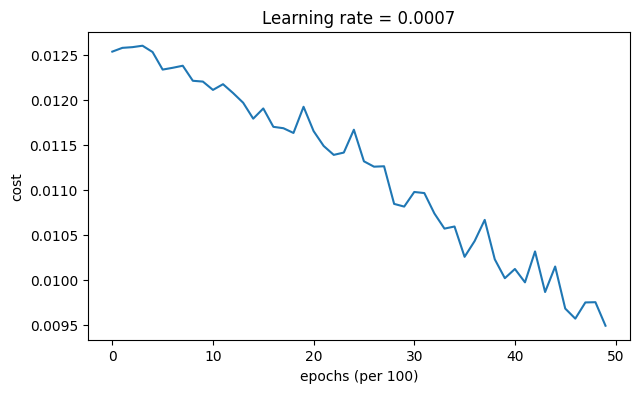

Accuracy: 0.8056872037914692


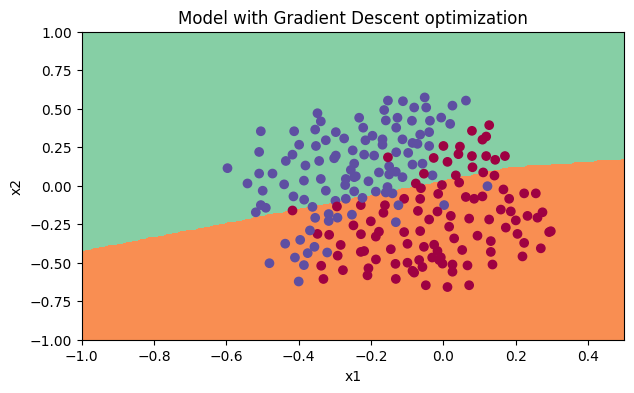

In [42]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model_with_optimization(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.0,0.5])
axes.set_ylim([-1,1.0])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

<a name='6-2'></a>  
### 6.2 - Mini-Batch Gradient Descent with Momentum

Next, run the following code to see how the model does with momentum. Because this example is relatively simple, the gains from using momemtum are small - but for more complex problems you might see bigger gains.

Cost after epoch 0: 0.012538
Cost after epoch 1000: 0.012113
Cost after epoch 2000: 0.011656
Cost after epoch 3000: 0.010979
Cost after epoch 4000: 0.010122


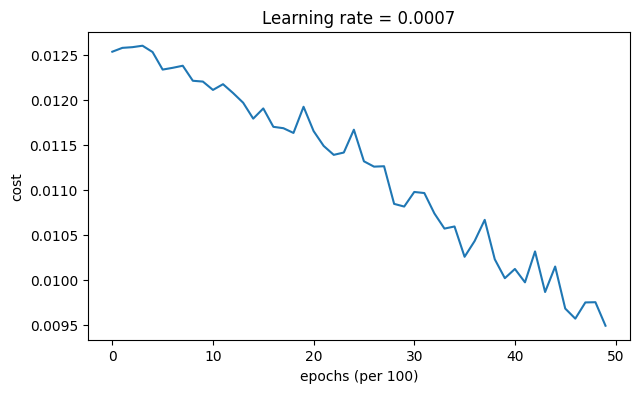

Accuracy: 0.8056872037914692


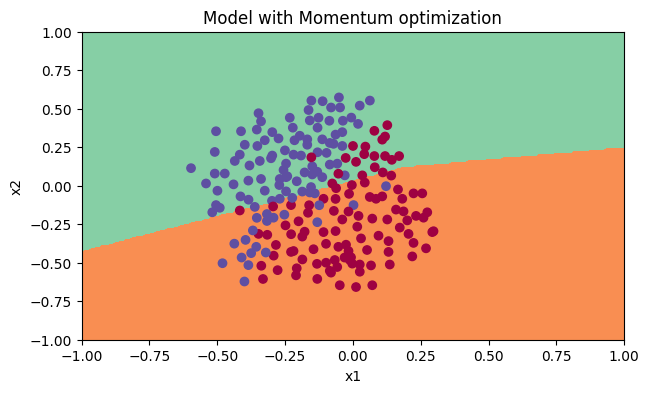

In [43]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model_with_optimization(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.0,1.0])
axes.set_ylim([-1.0,1.0])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Mini-Batch with Adam

Cost after epoch 0: 0.012531
Cost after epoch 1000: 0.005292
Cost after epoch 2000: 0.004453
Cost after epoch 3000: 0.005230
Cost after epoch 4000: 0.004088


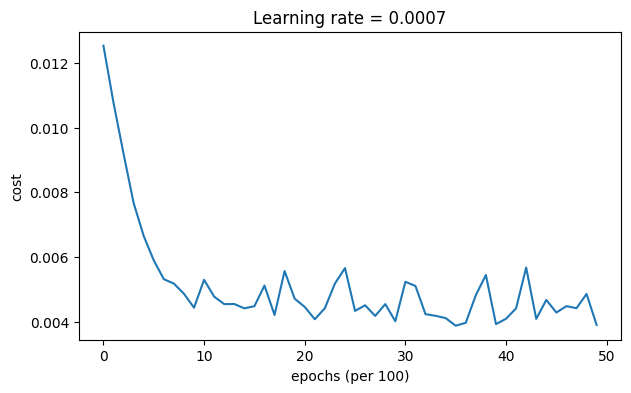

Accuracy: 0.9241706161137441


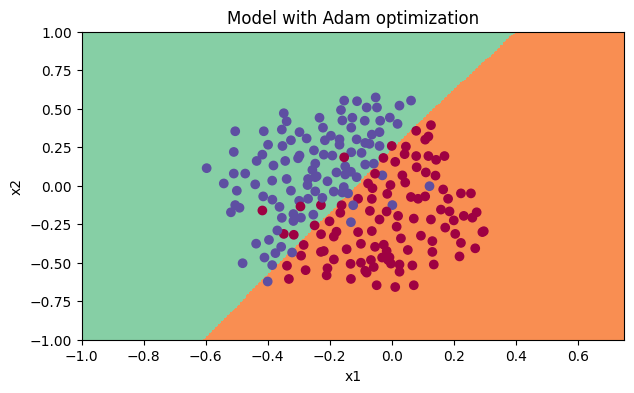

In [44]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model_with_optimization(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.0, 0.75])
axes.set_ylim([-1,1.0])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

<a name='6-4'></a>  
### 6.4 - Summary

<table> 
    <tr>
        <td>
        <b>optimization method</b>
        </td>
        <td>
        <b>accuracy</b>
        </td>
        <td>
        <b>cost shape</b>
        </td>
    </tr>
        <td>
        Gradient descent
        </td>
        <td>
        >71%
        </td>
        <td>
        smooth
        </td>
    <tr>
        <td>
        Momentum
        </td>
        <td>
        >71%
        </td>
        <td>
        smooth
        </td>
    </tr>
    <tr>
        <td>
        Adam
        </td>
        <td>
        >94%
        </td>
        <td>
        smoother
        </td>
    </tr>
</table> 

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligible.

On the other hand, Adam clearly outperforms mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:

- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)

**References**:

- Adam paper: https://arxiv.org/pdf/1412.6980.pdf

## 7 - Learning Rate Decay and Scheduling

Lastly, the learning rate is another hyperparameter that can help you speed up learning. 

During the first part of training, your model can get away with taking large steps, but over time, using a fixed value for the learning rate alpha can cause your model to get stuck in a wide oscillation that never quite converges. But if you were to slowly reduce your learning rate alpha over time, you could then take smaller, slower steps that bring you closer to the minimum. This is the idea behind learning rate decay. 

Learning rate decay can be achieved by using either adaptive methods or pre-defined learning rate schedules. 

Now, you'll apply scheduled learning rate decay to a 3-layer neural network in three different optimizer modes and see how each one differs, as well as the effect of scheduling at different epochs. 

This model is essentially the same as the one you used before, except in this one you'll be able to include learning rate decay. It includes two new parameters, decay and decay_rate. 

In [54]:
def model_with_lrate_decay(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True, decay=None, decay_rate=1):
    """
    Neural network model which can be run in different optimizer modes and includes learning rate decay
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs
    decay -- function that updates learning rate 
    decay_rate -- rate used to calculate extent of decaying in decay parameter function
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    lr_rates = []
    learning_rate0 = learning_rate   # the original learning rate
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0 # sum of costs over all mini batches in this epoch
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            AL, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += cost(AL, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(AL, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m

        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

#### Decay on every iteration  

For this portion of the assignment, you'll try one of the pre-defined schedules for learning rate decay, called exponential learning rate decay. It takes this mathematical form:

$$\alpha = \frac{1}{1 + decayRate \times epochNumber} \alpha_{0}$$


#### update_lr

Calculate the new learning rate using exponential weight decay.

In [55]:
def update_lr(learning_rate0, epoch_num, decay_rate):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer
    decay_rate -- Decay rate. Scalar

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """
    return learning_rate0 * (1 / (1 + (decay_rate * epoch_num)))

# All tests passed

Cost after epoch 0: 0.012515
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.011982
learning rate after epoch 1000: 0.000100
Cost after epoch 2000: 0.012051
learning rate after epoch 2000: 0.000050
Cost after epoch 3000: 0.011995
learning rate after epoch 3000: 0.000033
Cost after epoch 4000: 0.011880
learning rate after epoch 4000: 0.000025


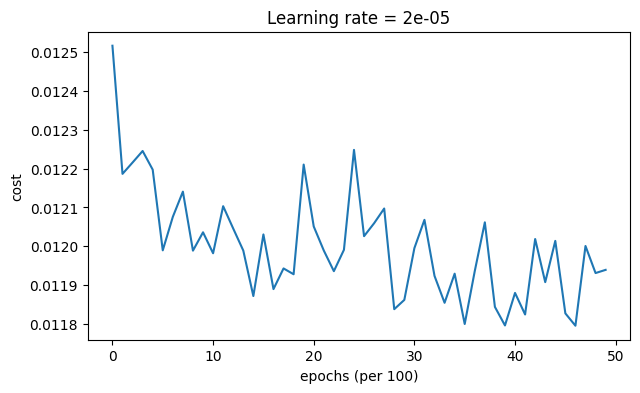

Accuracy: 0.7251184834123223


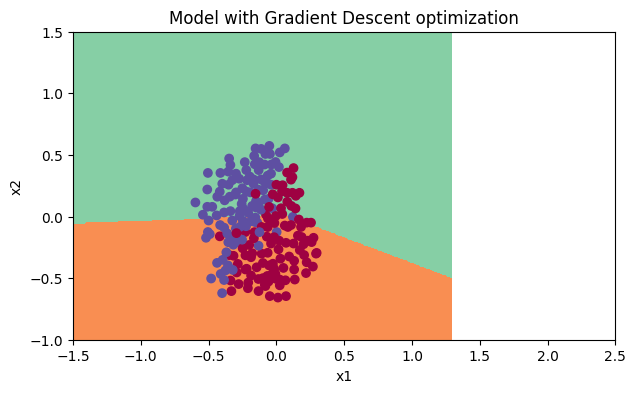

In [57]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model_with_lrate_decay(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=update_lr)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Notice that if you set the decay to occur at every iteration, the **learning rate goes to zero too quickly** - even if you start with a higher learning rate. 

When you're training for a few epoch this doesn't cause a lot of troubles, but **when the number of epochs is large the optimization algorithm will stop updating.** One common fix to this issue is to *decay the learning rate every few steps. This is called fixed interval scheduling.*

#### schedule_lr_decay

Calculate the new learning rate using exponential weight decay with fixed interval scheduling.

**Instructions**: Implement the learning rate scheduling such that it only changes when the epochNum is a multiple of the timeInterval.

**Note:** The fraction in the denominator uses the floor operation. 

$$\alpha = \frac{1}{1 + decayRate \times \lfloor\frac{epochNum}{timeInterval}\rfloor} \alpha_{0}$$

In [60]:
def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, timeInterval=1000):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer.
    decay_rate -- Decay rate. Scalar.
    time_interval -- Number of epochs where you update the learning rate.

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """

    return learning_rate0 / (1 + (decay_rate * (np.floor(epoch_num/timeInterval))))

# All tests passed

#### Using Learning Rate Decay for each Optimization Method

Below, you'll use the following "moons" dataset to test the different optimization methods. (The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.) 

##### Gradient Descent with Learning Rate Decay
Run the following code to see how the model does gradient descent and learning rate decay.

Cost after epoch 0: 0.012515
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.005067
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.004361
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.005174
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.004027
learning rate after epoch 4000: 0.020000


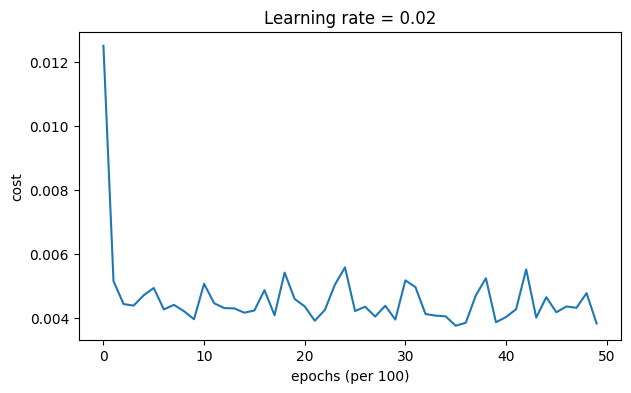

Accuracy: 0.9241706161137441


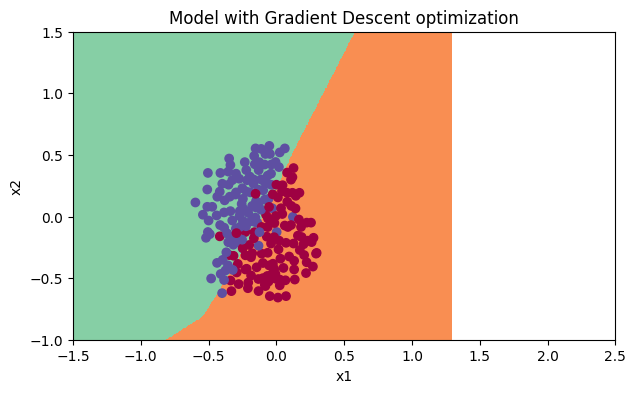

In [61]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model_with_lrate_decay(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

##### Gradient Descent with Momentum and Learning Rate Decay

Run the following code to see how the model does gradient descent with momentum and learning rate decay.

Cost after epoch 0: 0.012535
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.005063
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.004324
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.005149
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.004007
learning rate after epoch 4000: 0.020000


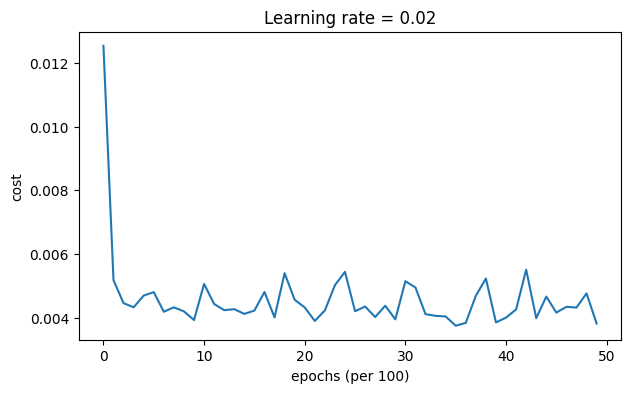

Accuracy: 0.9241706161137441


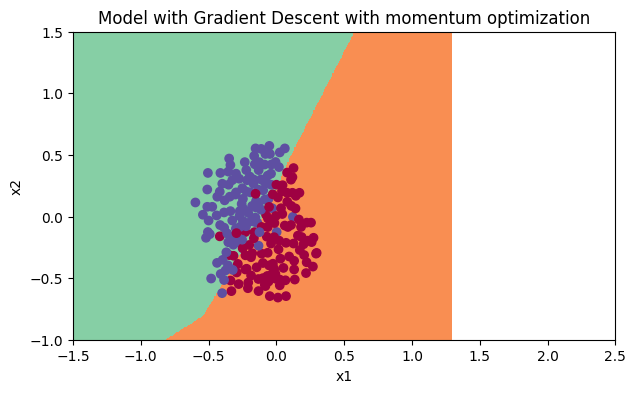

In [62]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model_with_lrate_decay(train_X, train_Y, layers_dims, optimizer = "momentum", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent with momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

##### Adam with Learning Rate Decay

Run the following code to see how the model does Adam and learning rate decay.

Cost after epoch 0: 0.012432
learning rate after epoch 0: 0.010000
Cost after epoch 1000: 0.004841
learning rate after epoch 1000: 0.005000
Cost after epoch 2000: 0.004023
learning rate after epoch 2000: 0.003333
Cost after epoch 3000: 0.004752
learning rate after epoch 3000: 0.002500
Cost after epoch 4000: 0.003864
learning rate after epoch 4000: 0.002000


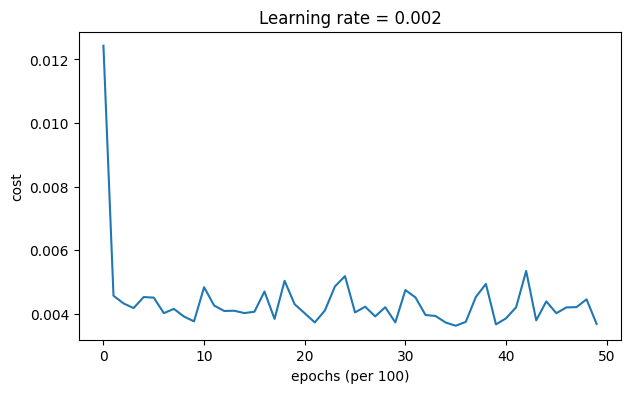

Accuracy: 0.9289099526066351


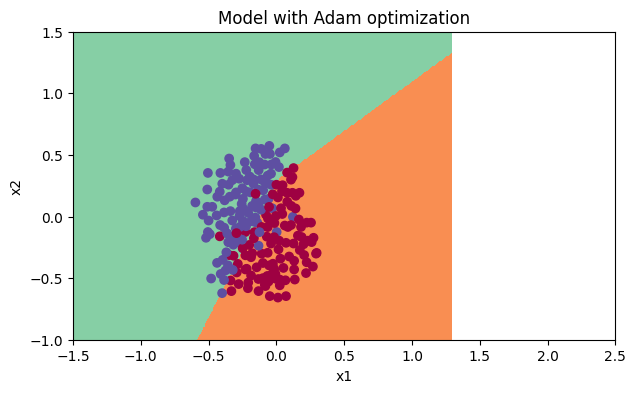

In [63]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model_with_lrate_decay(train_X, train_Y, layers_dims, optimizer = "adam", learning_rate = 0.01, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### Achieving similar performance with different methods

With Mini-batch GD or Mini-batch GD with Momentum, the accuracy is significantly lower than Adam, but when learning rate decay is added on top, either can achieve performance at a speed and accuracy score that's similar to Adam.

In the case of Adam, notice that the learning curve achieves a similar accuracy but faster.

Batch Normalization is implemented using TensorFlow in assignments.